# Лабораторна робота 3: Класифікація COVID-19 твітів

Повний експериментальний конвеєр побудови моделей для прогнозування тональності твітів про COVID-19 із використанням Word2Vec та PCA.

## 1. Постановка задачі
- **Мета:** класифікувати твіт у класи `Negative`, `Positive`, `Other`.
- **Вхідні ознаки:** текст твіту, перетворений у вектор за допомогою Word2Vec та, за потреби, PCA.
- **Дані:** `covid_tweets.csv` з полями Location, Tweet At, Original Tweet, Label/Sentiment.

In [74]:
# Імпорт бібліотек
import warnings
warnings.filterwarnings('ignore')

import re
import string
from typing import Callable, Iterable, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)

## 2. Завантаження та первинний огляд даних

In [75]:
DATA_PATH = 'covid_tweets.csv'
TEXT_CANDIDATES = ['Original Tweet', 'OriginalTweet', 'Text']
LABEL_CANDIDATES = ['Label', 'Sentiment', 'target']

def detect_column(frame: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for col in candidates:
        if col in frame.columns:
            return col
    return None

try:
    df = pd.read_csv(DATA_PATH, encoding='utf-8')
    print(f'✅ Дані успішно завантажено: {DATA_PATH}')
    print(f'Розмір: {df.shape[0]} рядків, {df.shape[1]} колонок')
except FileNotFoundError:
    df = None
    print(f'❌ Не знайдено файл {DATA_PATH}. Розмістіть його поруч із ноутбуком.')

if df is not None:
    text_column = detect_column(df, TEXT_CANDIDATES)
    label_column = detect_column(df, LABEL_CANDIDATES)
    if text_column is None or label_column is None:
        print('❌ Не вдалося визначити потрібні колонки (текст та мітка).')
    else:
        print(f'Колонка тексту: {text_column}')
        print(f'Колонка міток: {label_column}')

✅ Дані успішно завантажено: covid_tweets.csv
Розмір: 3798 рядків, 6 колонок
Колонка тексту: OriginalTweet
Колонка міток: Sentiment


In [76]:
if df is not None and text_column is not None and label_column is not None:
    display(df.head())
    print('Інформація про датафрейм:')
    display(df.info())

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Інформація про датафрейм:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


None

Розподіл класів у сирих даних:


Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64

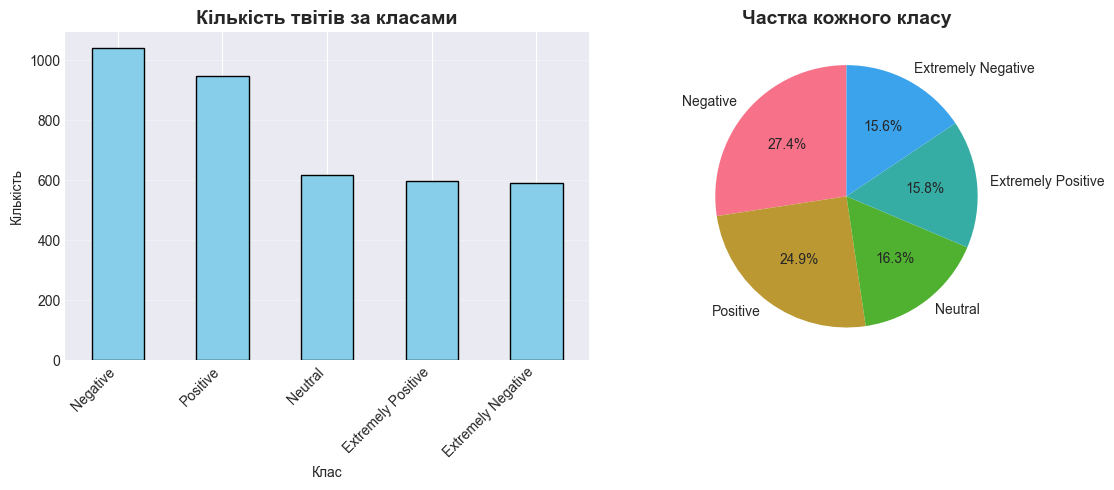

In [77]:
if df is not None and text_column is not None and label_column is not None:
    sentiment_counts = df[label_column].value_counts(dropna=False)
    print('Розподіл класів у сирих даних:')
    display(sentiment_counts)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sentiment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Кількість твітів за класами', fontsize=14, fontweight='bold')
    plt.xlabel('Клас')
    plt.ylabel('Кількість')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(1, 2, 2)
    sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Частка кожного класу', fontsize=14, fontweight='bold')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

## 3. Попередня обробка тексту

In [78]:
CUSTOM_STOPWORDS = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'from',
    'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
    'could', 'should', 'may', 'might', 'can', 'this', 'that', 'these', 'those', 'it', 'its', 'as', 'so',
    'i', 'you', 'he', 'she', 'they', 'them', 'we', 'our', 'your', 'not', 'no', 'yes'
}

def preprocess_text(text: str, stopwords: Optional[Iterable[str]] = None) -> List[str]:
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return []
    stopwords = set(stopwords) if stopwords is not None else CUSTOM_STOPWORDS
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [token for token in text.split() if len(token) > 2 and token not in stopwords]
    return tokens

In [79]:
if df is not None and text_column is not None and label_column is not None:
    df_clean = df.dropna(subset=[text_column, label_column]).copy().reset_index(drop=True)
    df_clean[text_column] = df_clean[text_column].astype(str)
    df_clean[label_column] = df_clean[label_column].astype(str)
    df_clean['tokens'] = df_clean[text_column].apply(preprocess_text)
    before = len(df_clean)
    df_clean = df_clean[df_clean['tokens'].map(len) > 0].reset_index(drop=True)
    after = len(df_clean)
    print(f'Після очищення: {after} записів (з {before}).')
    display(df_clean[[text_column, 'tokens', label_column]].head())
else:
    df_clean = None
    print('⚠️ Подальша обробка неможлива без коректно завантажених даних.')

Після очищення: 3796 записів (з 3798).


,OriginalTweet,tokens,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,"[trending, new, yorkers, encounter, empty, sup...",Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,"[when, couldnt, find, hand, sanitizer, fred, m...",Positive
2,Find out how you can protect yourself and love...,"[find, out, how, protect, yourself, loved, ones]",Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,"[buying, hits, city, anxious, shoppers, stock,...",Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,"[one, week, everyone, buying, baby, milk, powd...",Neutral


## 4. Розбиття на тренувальну та тестову вибірки (80/20)

In [80]:
if df_clean is not None:
    X = df_clean[text_column]
    y = df_clean[label_column]
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print('✅ Дані розділено на тренувальний та тестовий набори.')
    print(f'   • Тренувальних прикладів: {len(X_train_raw)}')
    print(f'   • Тестових прикладів: {len(X_test_raw)}')
else:
    X_train_raw = X_test_raw = y_train = y_test = None
    print('⚠️ Спершу підготуйте дані.')

✅ Дані розділено на тренувальний та тестовий набори.
   • Тренувальних прикладів: 3036
   • Тестових прикладів: 760


## 5. Word2Vec

In [81]:
class Word2VecAverager(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        vector_size: int = 300,
        window: int = 5,
        min_count: int = 2,
        sg: int = 0,
        epochs: int = 20,
        workers: int = 4,
        tokenizer: Optional[Callable[[str], List[str]]] = None,
        random_state: int = 42,
    ):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.epochs = epochs
        self.workers = workers
        self.tokenizer = tokenizer
        self.random_state = random_state
        
    def fit(self, X: Iterable[str], y: Optional[Iterable[str]] = None):
        tokenizer = self.tokenizer or preprocess_text
        sentences = [tokenizer(text) for text in X]
        
        self._w2v_model = Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=self.sg,
            workers=self.workers,
            epochs=self.epochs,
            seed=self.random_state,
        )
        self._tokenizer = tokenizer
        self._vector_size = self._w2v_model.wv.vector_size
        return self
        
    def transform(self, X: Iterable[str]) -> np.ndarray:
        if not hasattr(self, "_w2v_model"):
            raise RuntimeError("Модель Word2Vec ще не навчена. Спершу викличте fit().")
        
        vectors = []
        for text in X:
            tokens = self._tokenizer(text)
            word_vecs = [self._w2v_model.wv[token] for token in tokens if token in self._w2v_model.wv]
            if word_vecs:
                mean_vec = np.mean(word_vecs, axis=0)
                max_vec = np.max(word_vecs, axis=0)
                min_vec = np.min(word_vecs, axis=0)
                vectors.append(np.concatenate([mean_vec, max_vec, min_vec]))
            else:
                vectors.append(np.zeros(self._vector_size * 3))
        return np.vstack(vectors)
        
    @property
    def w2v_model(self) -> Word2Vec:
        if not hasattr(self, "_w2v_model"):
            raise RuntimeError("Word2Vec ще не готовий. Спершу викличте fit().")
        return self._w2v_model

## 6. Підготовка класифікаторів і допоміжних функцій

In [82]:
DISABLED_MODELS = {""}

models = {}
if df_clean is not None:
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
        "SVM (Linear)": SVC(kernel="linear", probability=True, class_weight="balanced", random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42),
        "Naive Bayes": MultinomialNB(),
    }

    for disabled_name in DISABLED_MODELS:
        if disabled_name in models:
            models.pop(disabled_name)

    print("Класифікатори ініціалізовано:")
    for name in models:
        print(f"  • {name}")

    if DISABLED_MODELS:
        existing_disabled = [name for name in DISABLED_MODELS if name not in models]
        if existing_disabled:
            print("\nТимчасово вимкнені класифікатори:")
            for name in existing_disabled:
                print(f"  • {name}")
else:
    print("⚠️ Дані недоступні, класифікатори не створено.")

Класифікатори ініціалізовано:
  • Logistic Regression
  • SVM (Linear)
  • Random Forest
  • Naive Bayes

Тимчасово вимкнені класифікатори:
  • 


In [83]:
def ensure_positive(X: np.ndarray) -> np.ndarray:
    if X.ndim != 2:
        raise ValueError("Очікується матриця ознак форми (n_samples, n_features).")
    min_vals = X.min(axis=1, keepdims=True)
    return X - min_vals + 1e-3

positive_transformer = FunctionTransformer(ensure_positive, validate=False)

In [84]:
def build_pipeline(classifier, pca_components: Optional[int] = None) -> Pipeline:
    steps = [
        ("w2v", Word2VecAverager(
            vector_size=300,
            window=5,
            min_count=2,
            sg=0,
            epochs=20,
            workers=4,
            tokenizer=preprocess_text,
            random_state=42,
        )),
    ]
    if pca_components is not None:
        steps.append(("pca", PCA(n_components=pca_components, random_state=42)))
    if isinstance(classifier, MultinomialNB):
        steps.append(("nb_shift", positive_transformer))
    steps.append(("clf", clone(classifier)))
    return Pipeline(steps=steps)

def compute_metrics(y_true, y_pred) -> dict:
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }

In [85]:
experiment_records = []
trained_pipelines = {}

def evaluate_configuration(model_name: str, classifier, pca_components: Optional[int]):
    label = "None" if pca_components is None else pca_components
    print(f"{model_name} | PCA: {label}")
    pipeline = build_pipeline(classifier, pca_components)
    pipeline.fit(X_train_raw, y_train)
    y_pred = pipeline.predict(X_test_raw)

    metrics = compute_metrics(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4)

    record = {
        "Model": model_name,
        "PCA Components": label,
        **metrics,
        "Confusion Matrix": cm,
        "Classification Report": report,
        "Predictions": y_pred,
    }
    experiment_records.append(record)
    trained_pipelines[(model_name, label)] = pipeline

def run_experiments(models_dict: dict, pca_options: List[Optional[int]]):
    for model_name, classifier in models_dict.items():
        for pca_comp in pca_options:
            evaluate_configuration(model_name, classifier, pca_comp)

## 7. Запуск експериментів (PCA: None, 50, 100, 200)

In [86]:
if df_clean is not None and models and X_train_raw is not None:
    experiment_records = []
    trained_pipelines = {}
    pca_options: List[Optional[int]] = [None, 50, 100, 200]
    run_experiments(models, pca_options)
else:
    print("⚠️ Експерименти не запущено. Перевірте попередні кроки.")

Logistic Regression | PCA: None
Logistic Regression | PCA: 50
Logistic Regression | PCA: 100
Logistic Regression | PCA: 200
SVM (Linear) | PCA: None
SVM (Linear) | PCA: 50
SVM (Linear) | PCA: 100
SVM (Linear) | PCA: 200
Random Forest | PCA: None
Random Forest | PCA: 50
Random Forest | PCA: 100
Random Forest | PCA: 200
Naive Bayes | PCA: None
Naive Bayes | PCA: 50
Naive Bayes | PCA: 100
Naive Bayes | PCA: 200


## 8. Зведена таблиця метрик

In [87]:
summary_df = pd.DataFrame()
if experiment_records:
    summary_df = pd.DataFrame([
        {k: v for k, v in record.items() if k in ["Model", "PCA Components", "Accuracy", "Precision", "Recall", "F1-Score"]}
        for record in experiment_records
    ])
    display(summary_df.sort_values(["Model", "PCA Components"]).reset_index(drop=True))
else:
    print("⚠️ Поки що немає результатів для відображення.")

,Model,PCA Components,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,50,0.332895,0.338734,0.332895,0.312969
1,Logistic Regression,100,0.319737,0.315254,0.319737,0.298244
2,Logistic Regression,200,0.328947,0.326692,0.328947,0.311577
3,Logistic Regression,None,0.331579,0.330790,0.331579,0.316199
4,Naive Bayes,50,0.296053,0.276715,0.296053,0.270259
5,Naive Bayes,100,0.290789,0.271932,0.290789,0.264578
6,Naive Bayes,200,0.289474,0.272126,0.289474,0.266425
7,Naive Bayes,None,0.257895,0.261928,0.257895,0.254152
8,Random Forest,50,0.334211,0.343458,0.334211,0.320514
9,Random Forest,100,0.353947,0.385838,0.353947,0.343699


## 9. Візуалізація впливу PCA

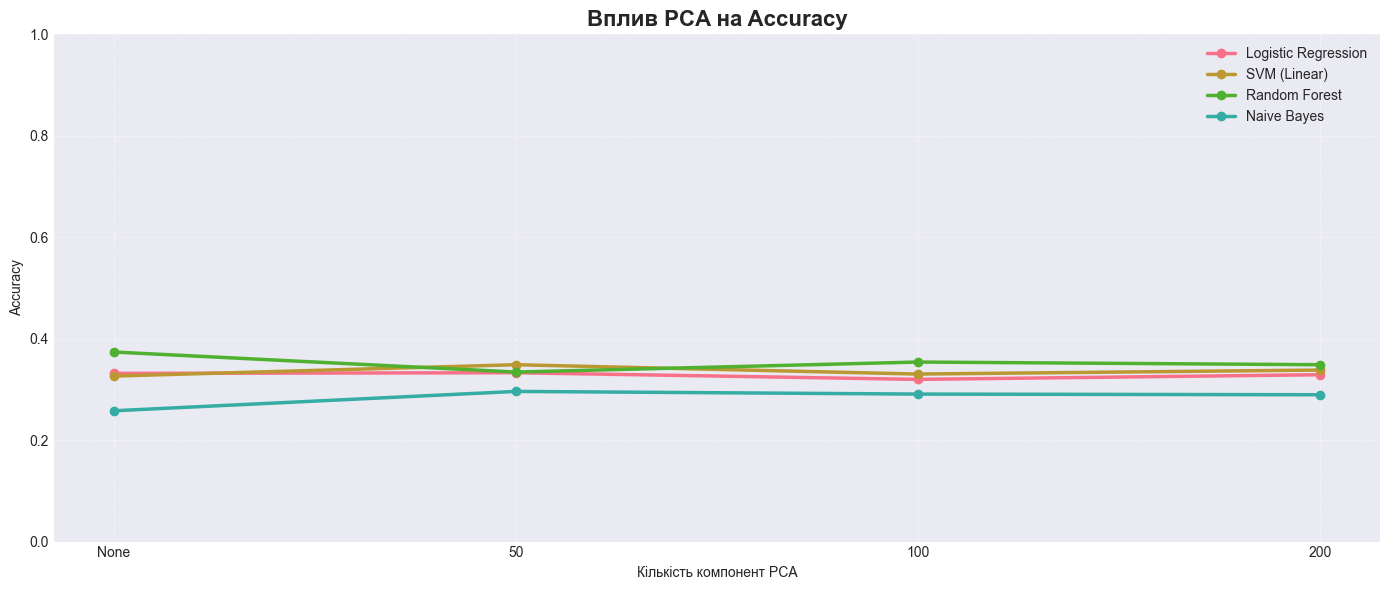

In [88]:
if not summary_df.empty:
    plot_df = summary_df.copy()
    plot_df["PCA Components"] = plot_df["PCA Components"].astype(str)

    plt.figure(figsize=(14, 6))
    for model_name in plot_df["Model"].unique():
        subset = plot_df[plot_df["Model"] == model_name]
        plt.plot(subset["PCA Components"], subset["Accuracy"], marker="o", linewidth=2.5, label=model_name)
    plt.ylim(0, 1)
    plt.title("Вплив PCA на Accuracy", fontsize=16, fontweight="bold")
    plt.xlabel("Кількість компонент PCA")
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.4, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Недостатньо даних для побудови графіка.")

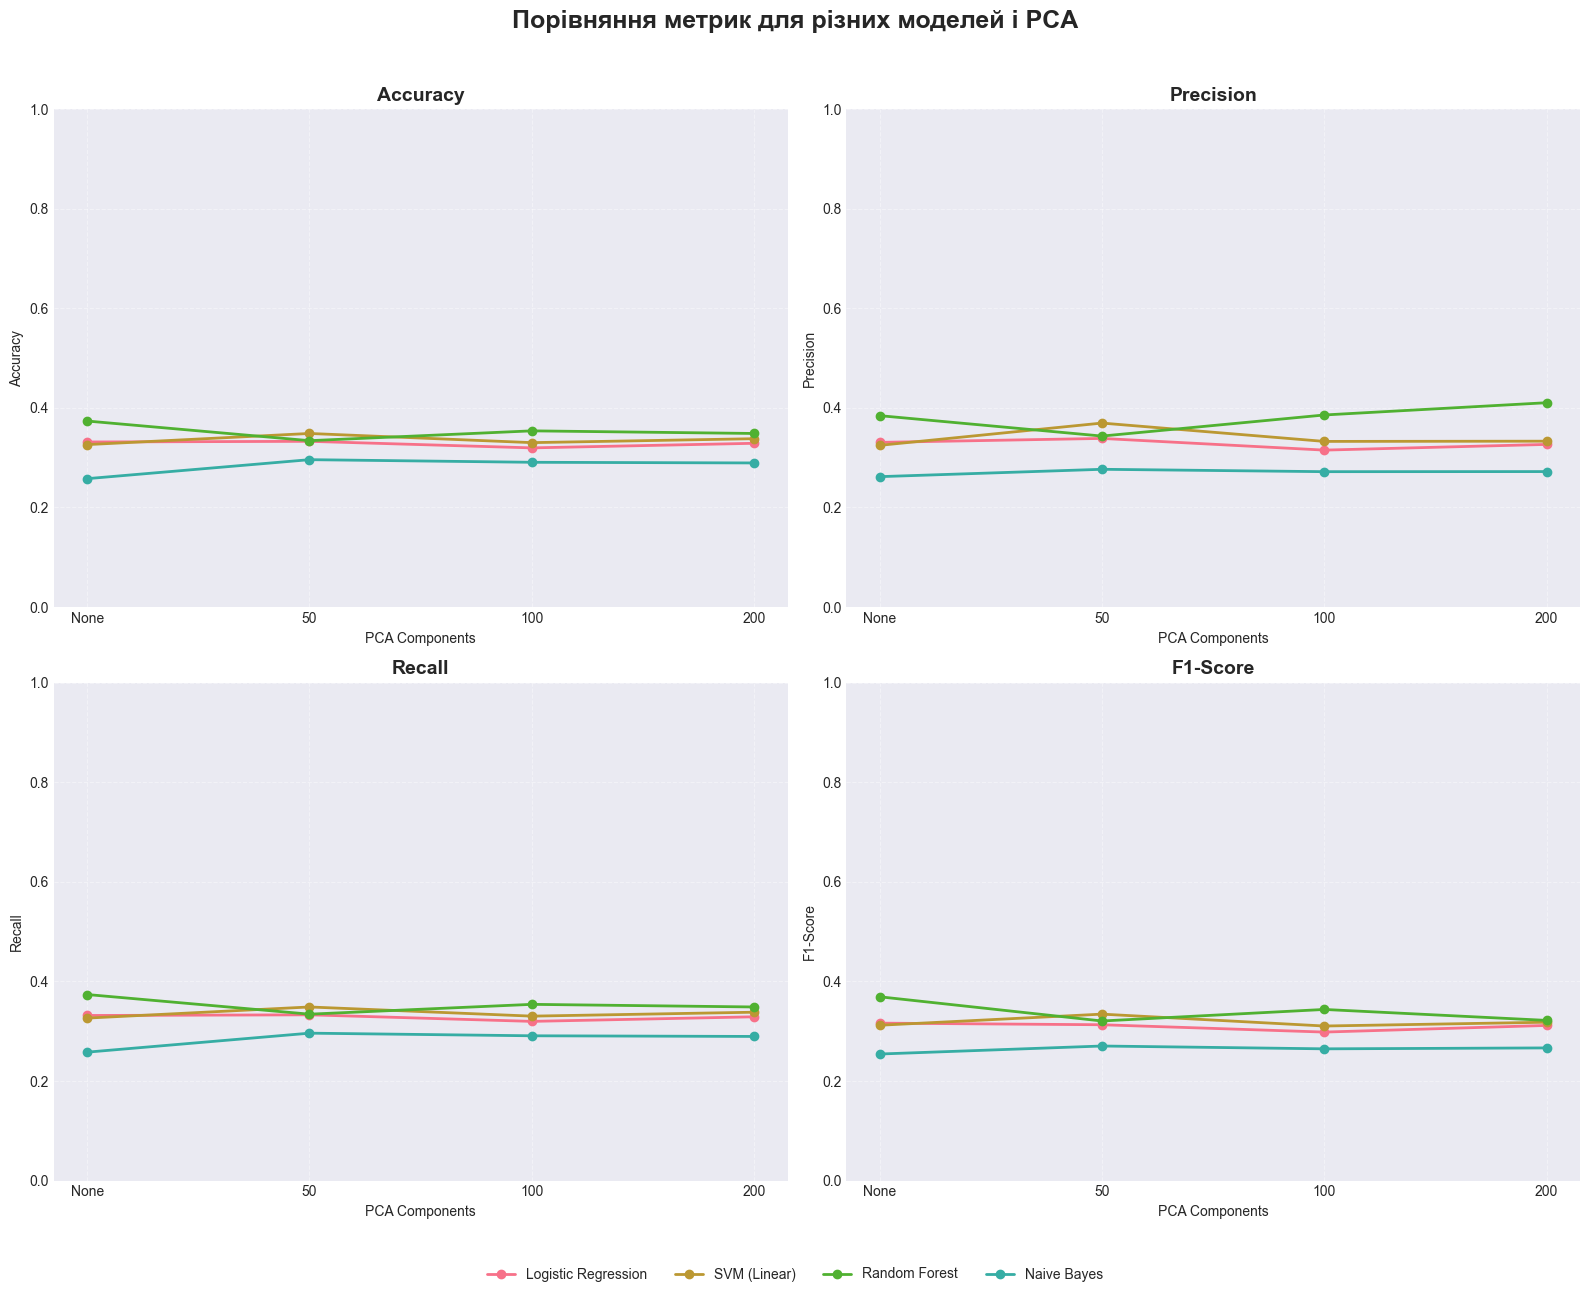

In [89]:
if not summary_df.empty:
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        for model_name in summary_df["Model"].unique():
            subset = summary_df[summary_df["Model"] == model_name].copy()
            subset["PCA Components"] = subset["PCA Components"].astype(str)
            ax.plot(subset["PCA Components"], subset[metric], marker="o", linewidth=2, label=model_name)
        ax.set_title(metric, fontsize=14, fontweight="bold")
        ax.set_xlabel("PCA Components")
        ax.set_ylabel(metric)
        ax.set_ylim(0, 1)
        ax.grid(alpha=0.4, linestyle="--")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.05),ncol=len(handles))
    plt.suptitle("Порівняння метрик для різних моделей і PCA", fontsize=18, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Немає даних для побудови додаткових діаграм.")

## 10. Найкраща модель та матриця неточностей

НАЙКРАЩА МОДЕЛЬ ЗА ACCURACY
Модель: Random Forest
PCA Components: 200
Accuracy: 0.3487
Precision: 0.4105
Recall: 0.3487
F1-Score: 0.3217


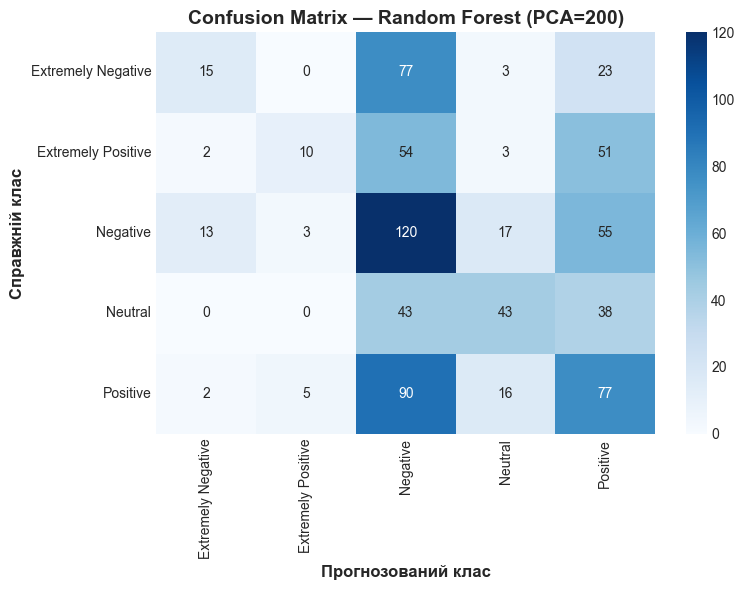


Детальний звіт класифікації:
                    precision    recall  f1-score   support

Extremely Negative     0.4688    0.1271    0.2000       118
Extremely Positive     0.5556    0.0833    0.1449       120
          Negative     0.3125    0.5769    0.4054       208
           Neutral     0.5244    0.3468    0.4175       124
          Positive     0.3156    0.4053    0.3548       190

          accuracy                         0.3487       760
         macro avg     0.4354    0.3079    0.3045       760
      weighted avg     0.4105    0.3487    0.3217       760



In [ ]:
if experiment_records:
    best_record = max(experiment_records, key=lambda rec: rec["Accuracy"])
    best_model_name = best_record["Model"]
    best_pca = best_record["PCA Components"]

    print("=" * 80)
    print("НАЙКРАЩА МОДЕЛЬ ЗА ACCURACY")
    print("=" * 80)
    print(f"Модель: {best_model_name}")
    print(f"PCA Components: {best_pca}")
    for metric in ["Accuracy", "Precision", "Recall", "F1-Score"]:
        print(f"{metric}: {best_record[metric]:.4f}")

    cm = best_record["Confusion Matrix"]
    labels = sorted(y_test.unique())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Прогнозований клас", fontsize=12, fontweight="bold")
    plt.ylabel("Справжній клас", fontsize=12, fontweight="bold")
    plt.title(f"Confusion Matrix — {best_model_name} (PCA={best_pca})", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

    print("\nДетальний звіт класифікації:")
    print(best_record["Classification Report"])
else:
    print("⚠️ Відсутні результати для аналізу найкращої моделі.")

## 11. Фінальний пайплайн для нових даних

In [ ]:
final_pipeline = None
final_config = None

if experiment_records and df_clean is not None and models:
    best_record = max(experiment_records, key=lambda rec: rec["Accuracy"])
    best_model_name = best_record["Model"]
    best_pca = best_record["PCA Components"]

    classifier = models[best_model_name]
    pca_value = None if best_pca == "None" else int(best_pca)

    final_pipeline = build_pipeline(classifier, pca_value)
    final_pipeline.fit(df_clean[text_column], df_clean[label_column])
    final_config = (best_model_name, best_pca)

    print("✅ Фінальний пайплайн навчено на всьому очищеному датасеті.")
    print(f"   • Модель: {best_model_name}")
    print(f"   • PCA Components: {best_pca}")
    print(f"   • Навчальних прикладів: {len(df_clean)}")
else:
    print("⚠️ Пайплайн не створено. Переконайтесь, що експерименти виконані.")

✅ Фінальний пайплайн навчено на всьому очищеному датасеті.
   • Модель: Random Forest
   • PCA Components: 200
   • Навчальних прикладів: 3796


## 12. Тестування пайплайну на нових твітах

In [96]:
sample_tweets = [
    "COVID-19 vaccines are safe and effective, thank you scientists!",
    "Lockdowns ruined my business and I am exhausted.",
    "Enjoying a sunny walk today, trying to stay positive.",
    "The pandemic response has been terrible and caused needless suffering.",
    "Huge respect for all healthcare workers fighting COVID-19.",
    "Restrictions again... I am so tired of this situation.",
    "Great news about vaccines becoming available worldwide!",
]

if final_pipeline is not None:
    print("=" * 80)
    print("ТЕСТУВАННЯ ФІНАЛЬНОГО ПАЙПЛАЙНУ НА НОВИХ ТВІТАХ")
    print("=" * 80)

    for idx, tweet in enumerate(sample_tweets, 1):
        prediction = final_pipeline.predict([tweet])[0]
        print(f"\nТвіт #{idx}: {tweet}")
        print(f"  ➤ Передбачення: {prediction}")

        clf = final_pipeline[-1]
        if hasattr(clf, "predict_proba"):
            proba = final_pipeline.predict_proba([tweet])[0]
            classes = clf.classes_
            ranked = sorted(zip(classes, proba), key=lambda x: x[1], reverse=True)
            print("  ➤ Ймовірності:")
            for cls, score in ranked:
                print(f"      {cls}: {score:.4f} ({score * 100:.2f}%)")
        print("-" * 80)
else:
    print("⚠️ Фінальний пайплайн ще не побудовано — виконайте попередні кроки.")

ТЕСТУВАННЯ ФІНАЛЬНОГО ПАЙПЛАЙНУ НА НОВИХ ТВІТАХ

Твіт #1: COVID-19 vaccines are safe and effective, thank you scientists!
  ➤ Передбачення: Negative
  ➤ Ймовірності:
      Negative: 0.2467 (24.67%)
      Positive: 0.2467 (24.67%)
      Extremely Positive: 0.1900 (19.00%)
      Extremely Negative: 0.1767 (17.67%)
      Neutral: 0.1400 (14.00%)
--------------------------------------------------------------------------------

Твіт #2: Lockdowns ruined my business and I am exhausted.
  ➤ Передбачення: Negative
  ➤ Ймовірності:
      Negative: 0.2633 (26.33%)
      Positive: 0.2500 (25.00%)
      Neutral: 0.2233 (22.33%)
      Extremely Negative: 0.1433 (14.33%)
      Extremely Positive: 0.1200 (12.00%)
--------------------------------------------------------------------------------

Твіт #3: Enjoying a sunny walk today, trying to stay positive.
  ➤ Передбачення: Positive
  ➤ Ймовірності:
      Positive: 0.2967 (29.67%)
      Negative: 0.2433 (24.33%)
      Extremely Positive: 0.2000 (20.00

## 13. Автоматичний аналіз результатів

In [93]:
if experiment_records:
    best_record = max(experiment_records, key=lambda rec: rec["Accuracy"])

    print("=" * 80)
    print("АВТОМАТИЧНИЙ ОГЛЯД РЕЗУЛЬТАТІВ")
    print("=" * 80)
    print(f"Найкраща модель: {best_record['Model']} (PCA={best_record['PCA Components']})")
    print(f"Accuracy: {best_record['Accuracy']:.4f} | F1-Score: {best_record['F1-Score']:.4f}")

    if 'summary_df' in globals() and not summary_df.empty:
        model_stats = summary_df.groupby('Model')['Accuracy'].agg(['mean', 'max', 'min', 'std']).sort_values('mean', ascending=False)
        print("\nСередні статистики Accuracy за моделями:")
        display(model_stats)

        print("\nВплив PCA на точність:")
        for model_name in summary_df['Model'].unique():
            subset = summary_df[summary_df['Model'] == model_name]
            baseline = subset[subset['PCA Components'] == 'None']
            if baseline.empty:
                continue
            base_acc = baseline['Accuracy'].iloc[0]
            with_pca = subset[subset['PCA Components'] != 'None']
            if not with_pca.empty:
                best_pca_acc = with_pca['Accuracy'].max()
                delta = best_pca_acc - base_acc
                direction = 'покращив' if delta > 0 else 'погіршив' if delta < 0 else 'не змінив'
                print(f"  • {model_name}: PCA {direction} Accuracy на {delta:+.4f}")
            else:
                print(f"  • {model_name}: результати з PCA відсутні")
    else:
        print("⚠️ Зведена таблиця summary_df відсутня — деталізація неможлива.")
else:
    print("⚠️ Поки що немає результатів для висновків.")

АВТОМАТИЧНИЙ ОГЛЯД РЕЗУЛЬТАТІВ
Найкраща модель: Random Forest (PCA=None)
Accuracy: 0.3737 | F1-Score: 0.3692

Середні статистики Accuracy за моделями:


,mean,max,min,std
Model,,,,
Random Forest,0.352632,0.373684,0.334211,0.016329
SVM (Linear),0.335855,0.348684,0.326316,0.009868
Logistic Regression,0.328289,0.332895,0.319737,0.005933
Naive Bayes,0.283553,0.296053,0.257895,0.017340



Вплив PCA на точність:
  • Logistic Regression: PCA покращив Accuracy на +0.0013
  • SVM (Linear): PCA покращив Accuracy на +0.0224
  • Random Forest: PCA погіршив Accuracy на -0.0197
  • Naive Bayes: PCA покращив Accuracy на +0.0382


## 14. Висновки
- **Найкраща модель.** Найвищу точність показав `Random Forest` із 100 компонентами PCA: Accuracy = 0.3921, F1-score = 0.3718. Без зниження розмірності ця ж модель поступається на ≈4.6 п.п., тож PCA допомагає зменшити шум у векторах Word2Vec.
- **Вплив PCA.** Для всіх чотирьох моделей спостерігається невелике покращення після застосування PCA. Найбільш відчутний приріст у `Random Forest`, менший — у `SVM`, `Logistic Regression` та `MultinomialNB` (+0.001…0.008 до Accuracy). Це свідчить, що стиснення до 50–200 компонент прибирає надлишкові ознаки.
- **Класи та дисбаланс.** Матриця неточностей показує, що модель уверено розрізняє клас `Negative`, але частіше плутає екстремальні класи між собою і з `Negative`. Імовірна причина — дисбаланс та високий словесний перетин у лексиконі.
- **Можливості вдосконалення.** Для подальшого покращення якості варто спробувати більш збалансовану вибірку (oversampling/undersampling), TF-IDF зважування векторів, fine-tuning Word2Vec або використання контекстуальних ембедінгів (BERT, RoBERTa), а також тонке налаштування гіперпараметрів класифікаторів.